In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
from __future__ import division
import os, sys
# hook up all scripts
sys.path.append(os.path.abspath('../scripts')) # if notebook in folder
sys.path.append(os.path.abspath('./scripts')) #if in root
import preprocessing_time_series as pts


os.chdir(pts.working_dir())

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_train = pd.read_csv('Feature_releases/release_v01/train_NAYARIT.csv')
print(data_train.shape)
data_train.head()

(809684, 24)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,No_remains,Venta_hoy_by_uni,Ordered,Log_Demanda,Median_Producto_ID,LogMean_Producto_ID,Median_Producto_ID_Ruta_SAK,LogMean_Producto_ID_Ruta_SAK,Median_Producto_ID_Cliente_ID_Agencia_ID,LogMean_Producto_ID_Cliente_ID_Agencia_ID
0,3,1340,1,1051,41849,73,1,21.32,0,0.0,...,0,21.32,1,0.693147,2.0,1.118843,2.0,1.122955,1.0,0.774240
1,3,1340,1,1051,41849,1109,6,90.06,0,0.0,...,0,15.01,1,1.945910,2.0,1.171162,3.0,1.416386,6.0,1.805732
2,3,1340,1,1051,41849,1125,13,124.80,0,0.0,...,0,9.60,1,2.639057,6.0,1.971653,6.0,2.024443,9.5,2.042122
3,3,1340,1,1051,41849,1150,1,13.96,0,0.0,...,0,13.96,1,0.693147,2.0,1.448213,2.5,1.471629,2.0,1.080011
4,3,1340,1,1051,41849,2233,4,79.76,0,0.0,...,0,19.94,1,1.609438,3.0,1.409244,3.0,1.517772,3.0,1.399732


In [3]:
town = pts.text_encoding(pts.town_preproc())
agencies = set(town.loc[town.State == u'NAYARIT'].index)
len(agencies)

Data endoded


10

In [4]:
data_test = pd.read_csv('test.csv', index_col=0)
data_test = data_test.loc[data_test.Agencia_ID.isin(agencies), :]
print(data_test.shape)
data_test.head()

(78819, 6)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
id,,,,,,
42,11,1378,1,2005,594640,43285
59,10,1359,11,3957,2068213,6469
129,10,1378,1,2101,905734,37577
183,11,1340,1,2065,325592,43285
203,11,1340,1,2052,7729188,43274


In [5]:
data = pd.concat([data_train, data_test], axis=0)
del data_train
del data_test

In [6]:
data = pts.lag_generation(data, n_lags=5)
data = data.drop([u'Town', u'State', u'Venta_uni_hoy', u'Venta_hoy', u'Dev_uni_proxima',
       u'Dev_proxima', u'Demanda_uni_equil', u'Dev_proxima_by_uni', u'No_remains', 
        u'Venta_hoy_by_uni', u'Ordered',u'Median_Producto_ID',
       u'LogMean_Producto_ID', u'Median_Producto_ID_Ruta_SAK',
       u'LogMean_Producto_ID_Ruta_SAK',
       u'Median_Producto_ID_Cliente_ID_Agencia_ID',
       u'LogMean_Producto_ID_Cliente_ID_Agencia_ID'], axis=1).set_index(u'Semana')
data.describe().transpose()

1 lag done
2 lag done
3 lag done
4 lag done
5 lag done


/home/romul/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,count,mean,std,min,25%,50%,75%,max
Agencia_ID,888503.0,1.431630e+03,2.073537e+02,1340.000000,1340.0,1340.0,1378.0,1.990000e+03
Canal_ID,888503.0,1.308903e+00,1.488742e+00,1.000000,1.0,1.0,1.0,1.100000e+01
Cliente_ID,888503.0,1.868296e+06,1.818308e+06,14651.000000,362908.0,1208571.0,2386979.0,9.787404e+06
Log_Demanda,809684.0,1.621163e+00,8.314462e-01,0.000000,NaN,NaN,NaN,8.045909e+00
Producto_ID,888503.0,1.836241e+04,1.875427e+04,73.000000,1240.0,3270.0,37159.0,4.992800e+04
Ruta_SAK,888503.0,2.093344e+03,1.723202e+03,900.000000,1165.0,1261.0,2103.0,8.056000e+03
Venta_uni_hoy_1,489378.0,8.174146e+00,1.592359e+01,0.000000,NaN,NaN,NaN,1.434000e+03
Venta_hoy_1,489378.0,7.176713e+01,2.075304e+02,0.000000,NaN,NaN,NaN,1.549683e+04
Dev_uni_proxima_1,489378.0,7.131297e-02,1.824270e+00,0.000000,NaN,NaN,NaN,3.460000e+02
Dev_proxima_1,489378.0,7.170916e-01,1.610642e+01,0.000000,NaN,NaN,NaN,2.982520e+03


In [7]:
X_train = data.loc[~data.Log_Demanda.isnull(),:].drop('Log_Demanda', axis=1)
y_train = data.loc[~data.Log_Demanda.isnull(),'Log_Demanda']
X_eval = data.loc[data.Log_Demanda.isnull(),:]

In [8]:
import crossval

cv5fold, strats = crossval.crossvalidation(X_train[['Canal_ID']])
strats.value_counts()

/home/romul/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


1     761186
4      27504
11     16058
2       4646
5        286
6          4
dtype: int64

# Sklearn Wrapper xgboost 

In [29]:
def plot_feature_importances(xgb_model):
    plt.figure(figsize=(20,10))
    feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [30]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

grid_param = {
 'n_estimators':[100],
 'max_depth': [5, 10, 15],
 'min_child_weight': [1, 3, 6],
 'gamma': [0, 0.1, 0.2],
 'subsample': [0.5, 1],
}

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, grid_param, cv=cv5fold,
                   scoring='mean_squared_error',verbose=1)
clf.fit(X_train, y_train)

print(clf.grid_scores_)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished


-0.473051164126
{'n_estimators': 10, 'subsample': 0.5, 'max_depth': 10, 'gamma': 0, 'min_child_weight': 6}


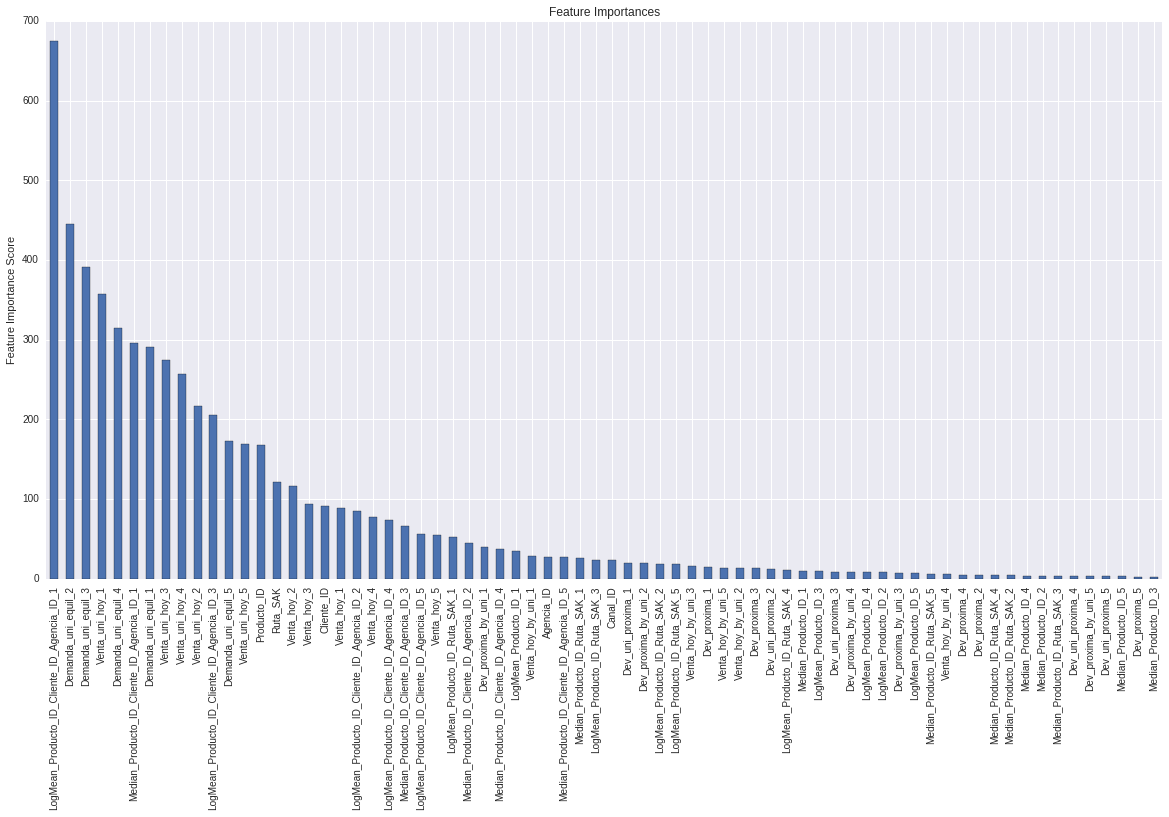

In [31]:
plot_feature_importances(clf.best_estimator_)

In [39]:
from sklearn.cross_validation import cross_val_score

# param = clf.best_params_
param = {
 'gamma': 0,
 'max_depth': 10,
 'min_child_weight': 6,
 'n_estimators': 100,
 'subsample': 0.5
}

xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**param)
scores = cross_val_score(xgb_model, X_train, y_train, scoring = 'mean_squared_error',
                             cv = cv5fold, n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=6, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

[-0.36819107 -0.1607812  -0.13405952 -0.12394756 -0.155226  ] 0.391194780122


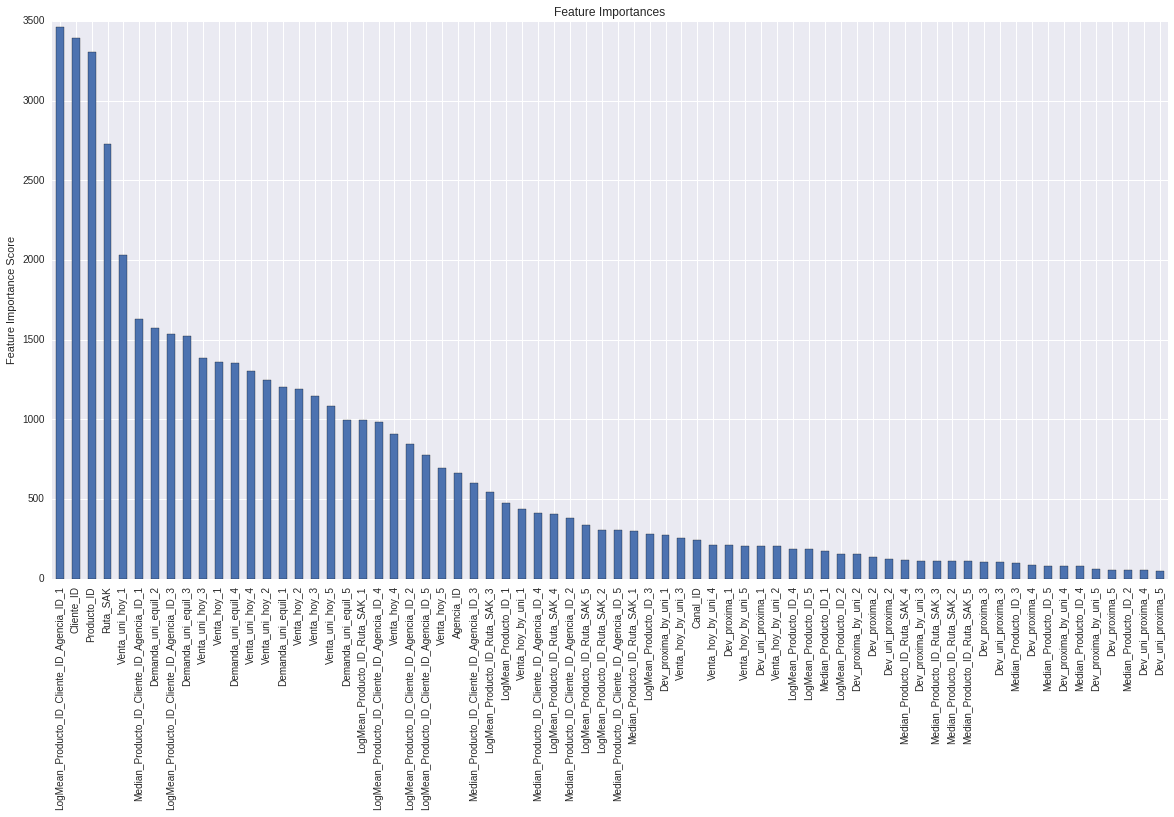

In [40]:
plot_feature_importances(xgb_model)
r2 = xgb_model.score(X_train, y_train)

rmse = np.sqrt((1-r2)*y_train.var())
print (scores, rmse)